In [1]:
# python functions
import sys
sys.path.append("./../")
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import matplotlib.pyplot as pl
import time 
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt


# jax function
from jax import random, vmap
from jax.api import jit, grad
import jax.numpy as np
from jax.nn.initializers import glorot_normal
from jax.experimental import optimizers
from jax.lib import xla_bridge
from jax.nn import softmax, relu
print('Is jax using GPU?', xla_bridge.get_backend().platform == 'gpu')


from neural_tangents.api import batch
from neural_tangents.api import get_ntk_fun_empirical
from neural_tangents import predict
from jax.lib import xla_bridge
from neural_tangents import stax


Is jax using GPU? True


In [2]:
# some settings for plots
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
# plt.rc('xlabel', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)
plt.rcParams.update({'font.size': 18})

## Load dataset

In [3]:
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../myData/MNIST_data/", one_hot=True)

dataset_size = 64

# '/tungstenfs/scratch/gzenke/liutian/myData/tfds/mnist'
train_images = mnist.train.images[:dataset_size, :]
train_labels = mnist.train.labels[:dataset_size, :]

# train = process_data(next(tfds.as_numpy(train)))
test_images = mnist.test.images[:dataset_size, :]
test_labels = mnist.test.labels[:dataset_size, :]

Extracting ../myData/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../myData/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../myData/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../myData/MNIST_data/t10k-labels-idx1-ubyte.gz


# Measuring the distance between two empirical NTKs of different initial parameters


Consider a two-hidden layer MLP $f(\cdot, \theta)$ of the architecture $784-l-l-10$, where 784 is the input layer width, $l$ is the hidden layer width, and 10 is the output layer width. For a fixed $l$, we will independtly sample two collections of parameters, $\theta_1$ and $\theta_2$. For each one of them, we evaluate its respective empirical NTK at a collection of input data $\mathcal{X}$. In our example, $\mathcal{X}$ is simply a set of 64 MNIST images. In this way, we get two empirical NTKs, $\mathcal{K}_{\theta_1}(\mathcal{X}, \mathcal{X})$ and $\mathcal{K}_{\theta_2}(\mathcal{X}, \mathcal{X})$. We will evaluate the $\| \mathcal{K}_{\theta_1}(\mathcal{X}, \mathcal{X}) - \mathcal{K}_{\theta_2}(\mathcal{X}, \mathcal{X}) \|_F^2 $, which is the sqaured Frobenius distance between these two NTK matrices. We repeat this procedure for increasingly wide hidden layer, where $l$ in ${128, 256, 512, 1024, 2048}$. 

We expect that the Frobenius distance decreases as the width of the hidden layer increases. This is because in the infinite width limit, the NTK should not depend on the choice of parameters anymore. However, as we will see, whether this behavoir can be observed depends on the details of weight-scaling of the MLP. In the following, we show three different setups:




We implement a MLP under NTK-scaling. Concretely, a densely connected layer is defined by,
$$x^{(l+1)} = \phi( \frac{\sigma_w}{\sqrt{N_{in}}} W^{(l+1)} x^{(l)} + \sigma_b b^{(l)})$$
where $W_{ij}, b_i\sim\mathcal N(0,1)$ at initialization and $\sigma_w, \sigma_b$ sets the scales of the weights and biases respectively, and $\phi$ is the relu activation.


In [4]:
widths = [2**i for i in range(7, 12)]


In [5]:
def scaled_f(params, image):
    # per-example predictions
    
    W_std=1.5
    
    b_std=0.05
    
    activations = image
        
    for w, b in params[:-1]:
        norm = W_std / np.sqrt(activations.shape[-1])

        outputs = norm * np.dot(activations, w) + b_std * b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    
    norm = W_std / np.sqrt(activations.shape[-1])
    logits = norm * np.dot(activations, final_w) + b_std * final_b
    return logits 

ntk_scaled_f = batch(get_ntk_fun_empirical(scaled_f), batch_size=16, device_count=0)



# Initialize all layers for a fully-connected neural network with sizes "sizes"
def scaled_init_network_params(sizes, key):
    # initialize a single layer
    def normal_random_layer_params(m, n, key):
        w_key, b_key = random.split(key)    


        return  random.normal(w_key, (m, n)),  random.normal(b_key, (1, n)).flatten()     
    
    keys = random.split(key, len(sizes))
    return [normal_random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


square_diffs = []    
for hidden_layer_width in widths:
        
    LAYER_SIZES = [784, hidden_layer_width, hidden_layer_width, 10]

    params1 = scaled_init_network_params(LAYER_SIZES, random.PRNGKey(1) )
    params2 = scaled_init_network_params(LAYER_SIZES, random.PRNGKey(2) )

    # two empirical NTKs
    g_dd1 = ntk_scaled_f(train_images, None, params1)
    g_dd2 = ntk_scaled_f(train_images, None, params2)

    # square diff between two NTKs
    square_diff = np.sum( (g_dd1 - g_dd2) **2 )
    square_diffs.append(square_diff)
    
    print('Hidden layer width %d | NTK diff %.2f '  % (hidden_layer_width, square_diff))



Hidden layer width 128 | NTK diff 1723.94 
Hidden layer width 256 | NTK diff 888.63 
Hidden layer width 512 | NTK diff 382.66 
Hidden layer width 1024 | NTK diff 219.39 
Hidden layer width 2048 | NTK diff 112.53 


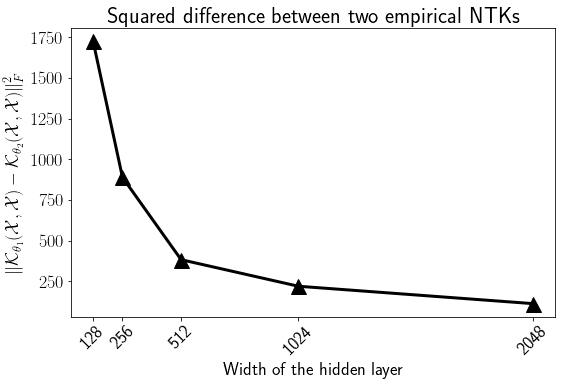

In [12]:

    
fig, ax = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97, hspace = 0.4)


ax.plot(widths, square_diffs, color = 'k', linestyle='-', lw = 3.0, marker = '^', markersize = 15.0)

ax.set_ylabel(r'$\displaystyle \| \mathcal{K}_{\theta_1}(\mathcal{X}, \mathcal{X}) - \mathcal{K}_{\theta_2}(\mathcal{X}, \mathcal{X})\|_F^2$', fontsize=18)
ax.set_xlabel('Width of the hidden layer', fontsize=18)

ax.set_xticks(widths)
ax.set_xticklabels(widths, rotation=45, fontsize= 18)
ax.set_title('Squared dist. between two empirical NTKs', fontsize= 22);

width = 8.0 
height = ( width / 1.618 )

fig.set_size_inches(width, height )


# Check the block diagonal property of empirical NTKs

Consider a MLP $f(\cdot, \theta)$ of the architecture $784-l-l-2$, where 784 is the input layer width, $l$ is the hidden layer width, and 2 is the output layer width. For a fixed $l$, we will sample parameters $\theta$ and evaluate its empirical NTK  at a collection of input data $\mathcal{X}$, denoted by $\mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X})$. In this example, $\mathcal{X}$ is simply a set of 16 MNIST images. For this reason, the $\mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X})$ is of the shape $(16, 16, 2, 2)$, where $16$ is the number of samples and $2$ is the output dimension. 

When the width of the MLP goes to infinity, the empirical NTK matrix $\mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X})$ is close to a block diagonal tensor. In our example here, this means $\mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X}) [:, :, 1, 0] \approx \mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X}) [:, :, 0, 1] = \mathbf{0}$ and $\mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X}) [:, :, 0, 0] \approx \mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X}) [:, :, 1, 1]$. In our experiment, we empirically check whether this is true. To this end, we calculate the "block diagonal distance"

"block diagonal distance" := $\| \mathcal{K}_{\theta}(\mathcal{X}, \mathcal{X}) [:, :, 1, 1] - \mathcal{K}_{\theta_2}(\mathcal{X}, \mathcal{X}) [:, :, 0, 0] \|_F^2 +  \|\mathcal{K}_{\theta} (\mathcal{X}, \mathcal{X})[:, :, 1, 0] \|_F^2 +  \|\mathcal{K}_{\theta}(\mathcal{X}) [:, :, 0, 1] \|_F^2$. 

We this value should be smaller and smaller as the width of MLP becomes larger and larger. To eliminate the influence of the choice of parameter $\theta$, we repeat the above procedure for tens of times and do an average for each width. 

In [7]:
NUM_RANDOM_SEEDS = 20

def scaled_f(params, image):
    # per-example predictions
    
    W_std=1.5
    
    b_std=0.05
    
    activations = image
        
    for w, b in params[:-1]:
        norm = W_std / np.sqrt(activations.shape[-1])

        outputs = norm * np.dot(activations, w) + b_std * b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    
    norm = W_std / np.sqrt(activations.shape[-1])
    logits = norm * np.dot(activations, final_w) + b_std * final_b
    return logits 

def scaled_init_network_params(sizes, key):
    # initialize a single layer
    def normal_random_layer_params(m, n, key):
        w_key, b_key = random.split(key)    

        return  random.normal(w_key, (m, n)),  random.normal(b_key, (1, n)).flatten()     
    
    keys = random.split(key, len(sizes))
    return [normal_random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]



# Make a batched version of the `predict` function

ntk_scaled_f = batch(get_ntk_fun_empirical(scaled_f), batch_size=16, device_count=0)

square_diffs_all_random_seeds_all_widths = []

for hidden_layer_width in widths:
        
    LAYER_SIZES = [784, hidden_layer_width, hidden_layer_width, 2]

    
    square_diff_all_random_seeds = []
    for random_seed in range(NUM_RANDOM_SEEDS):
#         _, params = init_fun(random.PRNGKey(random_seed), (-1, 28 * 28))
        params = scaled_init_network_params(LAYER_SIZES, random.PRNGKey(random_seed) )

        g_dd = ntk_scaled_f(train_images, None, params)

        square_diff = np.sum( (g_dd[..., 1, 1] - g_dd[..., 0, 0]) **2 ) + np.sum( (g_dd[..., 1, 0]) **2 ) + np.sum( (g_dd[..., 0, 1]) **2 )
        
        square_diff_all_random_seeds.append(square_diff)
        
    square_diffs_all_random_seeds_all_widths.append(square_diff_all_random_seeds)
    
    print('Hidden layer width %d | av. NTK diff %.2f '  % (hidden_layer_width, np.array(square_diffs_all_random_seeds_all_widths).mean()))

square_diffs_all_widths_av_random_seeds = np.mean(np.array(square_diffs_all_random_seeds_all_widths), axis = 1)


Hidden layer width 128 | av. NTK diff 36.02 
Hidden layer width 256 | av. NTK diff 25.59 
Hidden layer width 512 | av. NTK diff 19.21 
Hidden layer width 1024 | av. NTK diff 15.78 
Hidden layer width 2048 | av. NTK diff 13.02 


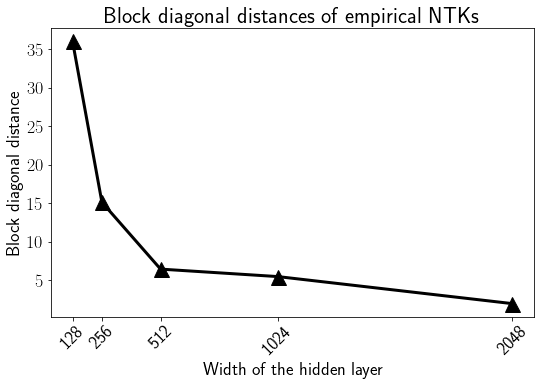

In [13]:

fig, ax = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97, hspace = 0.4)


ax.plot(widths, square_diffs_all_widths_av_random_seeds, color = 'k', linestyle='-', lw = 3.0, marker = '^', markersize = 15.0)

ax.set_ylabel('Block diagonal distance', fontsize=18)
ax.set_xlabel('Width of the hidden layer', fontsize=18)

ax.set_xticks(widths)
ax.set_xticklabels(widths, rotation=45, fontsize= 18)

ax.set_title('Block diagonal distances of empirical NTKs', fontsize=22);

fig.set_size_inches(width, height )


# Distances between empirical NTKs and analytic NTKs

We evaluate the distance of empirical NTK and analytic NTK. To do so, we put the empirical NTK matrices into the same shape of the analytic NTKs by compute an average across diagonal blocks.

In [9]:
square_diffs_empirical_analytic = []
for hidden_layer_width in widths:
# widths = 512    
    init_fun, f, ker_fun = stax.serial(
        stax.Dense(hidden_layer_width, W_std=1.5, b_std=0.05), stax.Relu(),
        stax.Dense(hidden_layer_width, W_std=1.5, b_std=0.05), stax.Relu(),
        stax.Dense(2, W_std=1.5, b_std=0.05) )

    ntk_empirical = batch(get_ntk_fun_empirical(f), batch_size=16, device_count=0)

    _, params = init_fun(random.PRNGKey(1), (-1, 28 * 28))

    # the empirical NTK
    empirical_ntk_evaluated_multiple_outputs = ntk_empirical(train_images, None, params)

    empirical_ntk_evaluated_compressed =  np.trace(empirical_ntk_evaluated_multiple_outputs, axis1=-2, axis2=-1) /empirical_ntk_evaluated_multiple_outputs.shape[-1]

    # the analytic NTK
    analytic_ntk_evaluated = ker_fun(train_images, train_images).ntk


    # the squared difference between (compressed) empirical NTK and analytic NTK
    square_diff = np.sum( (analytic_ntk_evaluated - empirical_ntk_evaluated_compressed )**2 ) 

    square_diffs_empirical_analytic.append(square_diff)

    print('Hidden layer width %d | NTK diff %.2f '  % (hidden_layer_width, square_diff))


Hidden layer width 128 | NTK diff 60.43 
Hidden layer width 256 | NTK diff 10.79 
Hidden layer width 512 | NTK diff 5.29 
Hidden layer width 1024 | NTK diff 4.51 
Hidden layer width 2048 | NTK diff 1.42 


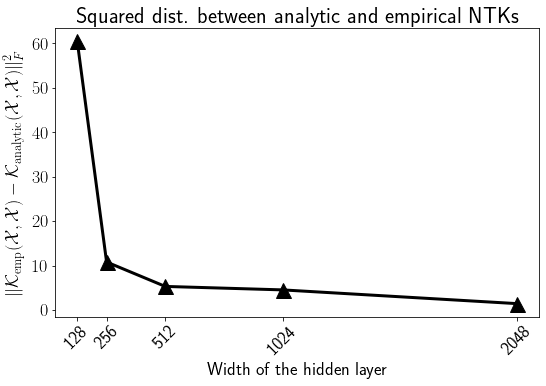

In [14]:
fig, ax = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97, hspace = 0.4)


ax.plot(widths, square_diffs_empirical_analytic, color = 'k', linestyle='-', lw = 3.0, marker = '^', markersize = 15.0)

ax.set_ylabel(r'$\displaystyle \| \mathcal{K}_{\mathrm{emp}}(\mathcal{X}, \mathcal{X}) - \mathcal{K}_{\mathrm{analytic}}(\mathcal{X}, \mathcal{X})\|_F^2$', fontsize=18)
ax.set_xlabel('Width of the hidden layer', fontsize=18)

ax.set_xticks(widths)
ax.set_xticklabels(widths, rotation=45, fontsize= 18)

ax.set_title('Squared dist. between analytic and empirical NTKs', fontsize=22);
fig.set_size_inches(width, height )
